In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import statsmodels.api as sm

wards = pd.read_csv('lsoa_ward.csv')
parquet_file = r"C:\Users\bella\Downloads\Y2Q4 JBG050 Data Challenge 2\clean_df.parquet"
dataset = pd.read_parquet(parquet_file, engine='pyarrow')
groups = dataset.groupby('Month')
wards.rename(columns={"LSOA21CD": "LSOA code", "LSOA21NM": "LSOA name"}, inplace=True)
# wards.head()
# dataset.head()
result = pd.merge(dataset, wards, on=['LSOA code', 'LSOA name'])

# Sarima

In [27]:
# Sets the timeseries start and end date, creates the timeseries, 
# gets the anomaly months, and averages those values
# Also creates the first difference time series.

data_start = date(2010, 12, 1)
data_end = date(2022, 9, 1)


sarima_timeseries = groups.count()['Longitude']
sarima_timeseries = pd.Series(sarima_timeseries.values,index=[pd.Timestamp(x, freq='M') for x in sarima_timeseries.index])
sarima_timeseries = sarima_timeseries[data_start:data_end]
sarima_df = pd.DataFrame(sarima_timeseries).reset_index()

remove_start = date(2019, 11, 1)
remove_end = date(2020, 7, 1)

def anomaly_avg(timestamp):
    temp = sarima_df[sarima_df['index'].dt.month == timestamp.month]
    temp = temp[temp['index'].dt.year != timestamp.year]
    return int(temp[0].mean())

corona_df = pd.DataFrame(sarima_timeseries[remove_start:remove_end]).reset_index()

for x in corona_df['index']:
    sarima_timeseries[x] = anomaly_avg(x)
    
sarima_timeseries_diff = sarima_timeseries.diff()[1:]
sarima_timeseries_diff = pd.Series(sarima_timeseries_diff.values,index=[pd.Timestamp(x) for x in sarima_timeseries_diff.index])

P-value of the time series: 0.626
P-value of the first differenced time series: 0.0


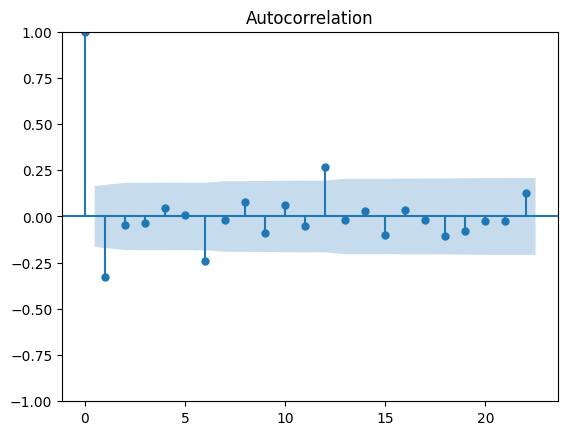

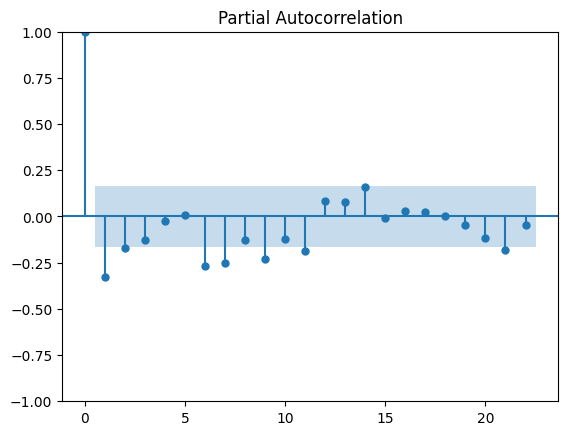

In [28]:
# Prints and plots the ACF and PACF plots and the augmented dickey fuller tests

plot_acf(sarima_timeseries_diff);
adfull_time = adfuller(sarima_timeseries)
print('P-value of the time series:', round(adfull_time[1], 3))
adfull_time = adfuller(sarima_timeseries_diff)
print('P-value of the first differenced time series:', round(adfull_time[1], 3))
plot_pacf(sarima_timeseries_diff, method='ywm');

In [31]:
def prepare_timeseries(timeseries):
    
    data_start = date(2010, 12, 1)
    data_end = date(2022, 9, 1)
    timeseries = pd.Series(timeseries.values,index=[pd.Timestamp(x, freq='M') for x in timeseries.index])
    timeseries = timeseries[data_start:data_end]
    
    return timeseries

def training(timeseries):

    train_end = date(2022, 1, 1)
    test_end = date(2022, 9, 1)

    train_data = timeseries[:train_end]
    test_data = timeseries[train_end+timedelta(days=1):test_end]
    
    return train_data, test_data

def corona_troubles(timeseries):
    remove_start = date(2019, 11, 1)
    remove_end = date(2020, 7, 1)
    temp_df = pd.DataFrame(timeseries).reset_index()
    
    
    for x in timeseries[remove_start:remove_end].index:
        temp = temp_df[temp_df['index'].dt.month == x.month]
        temp = temp[temp['index'].dt.year != x.year]
        timeseries[x] = int(temp[0].mean())
        
    return timeseries

def create_model(train_data, my_order, my_seasonal_order):
    my_order = (0,1,0)
    my_seasonal_order = (2, 0, 1, 6)
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    
    start = time()
    model_fit = model.fit()
    end = time()
#     print("Model Fitting Time:", end - start)
    
    return model_fit



def pred_res(model_fit, test_data):
    
    predictions = model_fit.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    
    return predictions, residuals

def plot_residuals(residuals):
    plt.figure(figsize=(10,4))
    plt.plot(residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title('Residuals from SARIMA Model', fontsize=20)
    plt.ylabel("Error", fontsize=16);
    
def plot_predictions(timeseries, predictions):
    plt.figure(figsize=(10,4))

    start_date = timeseries.index[0]
    end_date = timeseries.index[-1]

    plt.plot(timeseries)
    plt.plot(predictions)

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Amount of crimes in Barnet', fontsize=20)
    plt.ylabel('Crimes', fontsize=16)
    for year in range(start_date.year+1,end_date.year+1):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
def statistics(residuals, test_data):
#     print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
#     print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
    MAPE = round(np.mean(abs(residuals/test_data)),4)
    RMSE = np.sqrt(np.mean(residuals**2))
    return MAPE, RMSE
    
def rolling_pred_res(train_data, test_data, timeseries, my_order, my_seasonal_order):
    my_order = (0,1,0)
    my_seasonal_order = (2, 0, 1, 6)
    rolling_predictions = test_data.copy()
    for train_end in test_data.index:
        train_data = timeseries[:train_end-timedelta(days=1)]
        model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[train_end] = pred

    rolling_residuals = test_data - rolling_predictions
    
    return rolling_predictions, rolling_residuals

def plot_rolling_residuals(rolling_residuals):
    plt.figure(figsize=(10,4))
    plt.plot(rolling_residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
    plt.ylabel('Error', fontsize=16);
    

def plot_rolling_predictions(timeseries, rolling_predictions):
    plt.figure(figsize=(10,4))
    
    start_date = timeseries.index[0]
    end_date = timeseries.index[-1]

    plt.plot(timeseries)
    plt.plot(rolling_predictions)

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Rolling Forecast prediction Crimes in Barnet', fontsize=20)
    plt.ylabel('Crimes', fontsize=16)
    for year in range(start_date.year+1,end_date.year+1):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
        
def rolling_statistics(rolling_residuals, test_data):
#     print('Rolling Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))
#     print('Rolling Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))
    RMAPE = round(np.mean(abs(rolling_residuals/test_data)),4)
    RRMSE = np.sqrt(np.mean(rolling_residuals**2))
    
    return RMAPE, RRMSE

In [32]:
def run_functions(temp_timeseries):
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    temp_train, temp_test = training(temp_timeseries)
    
    temp_model_fit = create_model(temp_train, my_order, my_seasonal_order)
    temp_predictions, temp_residuals = pred_res(temp_model_fit, temp_test)
    plot_residuals(temp_residuals)
    plot_predictions(temp_timeseries, temp_predictions)
    temp_mape, temp_rmse = statistics(temp_residuals, temp_test)

    temp_rolling_predictions, temp_rolling_residuals = rolling_pred_res(temp_train, temp_test, temp_timeseries, my_order, my_seasonal_order)
    plot_rolling_residuals(temp_rolling_residuals)
    plot_rolling_predictions(temp_timeseries, temp_rolling_predictions)
    temp_rmape, temp_rrmse = rolling_statistics(temp_rolling_residuals, temp_test)
    
    return temp_rmape, temp_rrmse

In [33]:
# # Part that runs each individual ward with the same parameters as the big one
# rmse_lst = []
# mape_lst = []
# for x in result['WD22NM'].unique():
#     df_temp = result[result['WD22NM'] == x]
#     temp_timeseries = df_temp.groupby("Month").count()['Latitude']
#     x, y = run_functions(temp_timeseries)
#     mape_lst.append(x)
#     rmse_lst.append(y)

In [34]:
# copy_rmse_lst, copy_mape_lst

In [35]:
# Average mape with the same order and seasonal order in the model as the whole dataset
# np.mean(copy_mape_lst)
# 0.54426

In [35]:
result['WD22NM'].unique()

array(['High Barnet', 'Underhill', 'East Barnet', 'Barnet Vale',
       'Edgwarebury', 'Totteridge & Woodside', 'Whetstone',
       'Brunswick Park', 'Woodhouse', 'Edgware', 'Friern Barnet',
       'Mill Hill', 'Burnt Oak', 'West Finchley', 'Finchley Church End',
       'Colindale North', 'East Finchley', 'Hendon', 'Garden Suburb',
       'West Hendon', 'Golders Green', 'Childs Hill', 'Cricklewood'],
      dtype=object)

In [36]:
orders = []
for x in [0,1]:
    for y in [0,1]:
        for z in [0,1,2]:
            orders.append((x,y,z))
            
seasonal_orders = []
for x in [1,2]:
    for y in [0]:
        for z in [0,1]:
            for s in [6, 12]:
                seasonal_orders.append((x,y,z,s))

In [38]:
best_order_lst = []
i=0
for x in tqdm(result['WD22NM'].unique()):
    i+=1
    start= time()
    looking_lst = []
    for y in orders:
        for z in seasonal_orders:
            try:
                my_order = y
                my_seasonal_order = z
                df_temp = result[result['WD22NM'] == x]
                temp_timeseries = df_temp.groupby("Month").count()['Latitude']
                new_temp_mape, new_temp_rmse = run_functions(temp_timeseries)
                looking_lst.append([(x,y,z), new_temp_mape, new_temp_rmse])
            except:
                print((x,y,z), 'Does not work')
    
    lowest = 1
    for val in looking_lst:
        if val[1] < lowest:
            lowest = val[1]
            best = val
    best_order_lst.append(best)
    end = time()
    print('{} took {} seconds.'.format(x, end-start))
    print('Best:', best)
    

  0%|          | 0/23 [00:00<?, ?it/s]

('High Barnet', (0, 0, 2), (1, 0, 1, 6)) Does not work


In [1]:
best_order_lst

NameError: name 'best_order_lst' is not defined

In [ ]:
mape_lst = []
for x in best_order_lst:
    mape_lst.append(x[1])

In [ ]:
copy_best_order_lst = best_order_lst.copy()

In [23]:
# Average mape with the 'optimal' order for each of the wards (but wrong so only the last set of parameters one lmao)
#np.mean(mape_lst)  #(but wrong so only the last set of parameters one lmao)
# 0.4526

np.mean(mape_lst)
# 0.2696

0.2696043478260869

In [24]:
needs_work = []
for x in best_order_lst:
    if x[1] > 0.3:
        needs_work.append(x)

In [25]:
needs_work

[[('East Finchley', (1, 0, 2), (2, 0, 1, 12)), 0.3128, 3.517811819867572],
 [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5732, 9.17877987534291],
 [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631],
 [('Woodhouse', (0, 0, 1), (2, 0, 0, 6)), 0.314, 2.0],
 [('Brunswick Park', (1, 1, 1), (1, 0, 1, 12)), 0.3469, 2.1505813167606567],
 [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.372, 1.8371173070873836],
 [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946]]

In [86]:
def get_timeseries(ward):
    df_temp = result[result['WD22NM'] == ward]
    temp_timeseries = df_temp.groupby("Month").count()['Latitude']
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    
    return temp_timeseries

In [87]:
def run_arima_functions(ward, y):
    temp_timeseries = get_timeseries(ward)
    temp_train, temp_test = training(temp_timeseries)
    temp_preds, temp_res = rolling_pred_res_arima(temp_train, temp_test, temp_timeseries, y)
    temp_rmape, temp_rrse = rolling_statistics(temp_res, temp_test)

    return temp_rmape, temp_rrse

In [88]:
def rolling_pred_res_arima(train_data, test_data, timeseries, my_order):
#     my_order = (0,1,0)
    rolling_predictions = test_data.copy()
    for train_end in test_data.index:
        train_data = timeseries[:train_end-timedelta(days=1)]
        model = sm.tsa.arima.ARIMA(train_data, order=my_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[train_end] = pred

    rolling_residuals = test_data - rolling_predictions
    
    return rolling_predictions, rolling_residuals

In [91]:
orders = []
for x in [0,1,2]:
    for y in [0,1,2]:
        for z in [0,1,2]:
            orders.append((x,y,z))

In [92]:
needs_work_new_best = []
for x in needs_work:
    looking_lst = []
    start = time()
    for y in orders:
        temp_rmape, temp_rrse = run_arima_functions(x[0][0], y)
        looking_lst.append([(x[0][0],y), new_temp_mape, new_temp_rmse])
        
    lowest = 1
    for val in looking_lst:
        if val[1] < lowest:
            lowest = val[1]
            best = val
    needs_work_new_best.append(best)
    end = time()
    print('{} took {} seconds.'.format(x, end-start))
    print('Best:', best)
        
    

[('East Finchley', (1, 0, 2), (2, 0, 1, 12)), 0.3128, 3.517811819867572] took 18.655919075012207 seconds.
Best: [('East Finchley', (0, 0, 0)), 0.6187, 3.142451272494134]


KeyboardInterrupt: 

0.6187
